In [89]:
from __future__ import print_function, absolute_import
import pandas as pd, numpy as np
import traceback
import argparse
from concurrent.futures import TimeoutError
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import fitting
from scipy.odr import *
from scipy.optimize import minimize
from scipy.stats import chisquare
from sklearn.metrics import r2_score
from glob import glob
import P_Cyg as pc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
import astropy.units as u
%matplotlib inline
posterdir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Figures/Poster/"
figdir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Figures/"
fitter = fitting.LevMarLSQFitter()

In [2]:
def KDE(x,y,X=[],Y=[]):
    data = np.vstack([x, y]).T
    #Grid search for best KDE bandwidth
    params = {'bandwidth': np.linspace(np.min(np.diff(y)),np.max(np.diff(y)),100)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)

    KDE_bandwidth = grid.best_estimator_.bandwidth

    kde = grid.best_estimator_
    
    if len(X) == 0:
        X, Y = np.meshgrid(np.linspace(np.min(x),np.max(x),100), np.linspace(np.min(y),np.max(y),100))

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #compute the KDE on a 100x100 grid of points
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
    return X,Y,Z


def scplot(x,y,z,n=10):
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection="3d")
    ax.contourf3D(x,y,z,n,cmap='viridis')
    
    xrange=x.max()-x.min()
    yrange=y.max()-y.min()
    diff=xrange-yrange
    ax.set_ylim(y.min()-diff/2,y.max()+diff/2)
    print(xrange,(y.min()-diff/2)-(y.max()+diff/2))
    # Hide grid lines
    ax.grid(False)
    # Hide Background Color 
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Hide Z Axis 
    ax.w_zaxis.line.set_lw(0.)

    ax.set_xlabel(r"Stokes Q",size=20,fontname="Arial")
    ax.set_ylabel(r"Stokes U",size=20,fontname="Arial")

    ax.view_init(90, 90)
    
def ncplot(x,y,z,n=10):
    f = plt.figure(figsize = (5,5))
    ax = f.gca()
    out_obj = ax.contourf(x,y,z,n,cmap='viridis')
    #make sure axis are the same proportion
    xrange=x.max()-x.min()
    yrange=y.max()-y.min()
    if yrange < xrange:
        diff=xrange-yrange
        ax.set_ylim(y.min()-diff/2,y.max()+diff/2)
    elif xrange < yrange:
        diff=yrange-xrange
        ax.set_xlim(x.min()-diff/2,x.max()+diff/2)
    ax.set_xlabel(r"Stokes Q",size=20,fontname="Arial")
    ax.set_ylabel(r"Stokes U",size=20,fontname="Arial")
    return ax, out_obj

    
def find_ecc(Gaussian):
    if Gaussian.x_stddev >= Gaussian.y_stddev:
        ecc = np.sqrt(1.0 - (Gaussian.y_stddev.value/Gaussian.x_stddev.value)**2.0)
    else:
        ecc = np.sqrt(1.0 - (Gaussian.x_stddev.value/Gaussian.y_stddev.value)**2.0)
    return ecc


In [3]:
datadir = 'C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/'
txt = glob(datadir + 'hpolccd*r_hw.fits.txt')
ws,qs,us,es = [],[],[],[]
for f in txt:
    w,f,q,u,e = pc.txt_QU_data(f, 1000, radial_velocity=-8.9)
    ws.append(w)
    qs.append(q)
    us.append(u)
    es.append(e)
ave_qs,ave_us,variance = [],[],[]
for w,q,u,e in zip(ws,qs,us,es):
    line_q,line_u,line_e = [],[],[]
    for ww,qq,uu,ee in zip(w,q,u,e):
        if ww >= 6540 and ww <= 6600:
            line_q.append(qq)
            line_u.append(uu)
            line_e.append(ee)
    ave_qs.append(np.mean(line_q))
    ave_us.append(np.mean(line_u))
    variance.append(1/(np.mean(line_e)**2))
ave_qs,ave_us,variance = np.array(ave_qs),np.array(ave_us),np.array(variance)

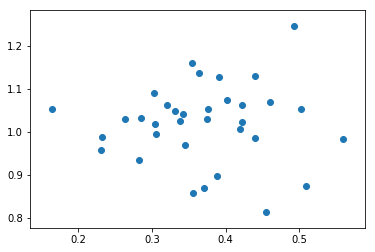

In [4]:
plt.scatter(ave_qs,ave_us)

In [16]:
x,y = ave_qs,ave_us
X,Y,Z = KDE(x,y)
Xo,Yo,Zo = X,Y,Z

C:\Users\Keyan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Keyan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


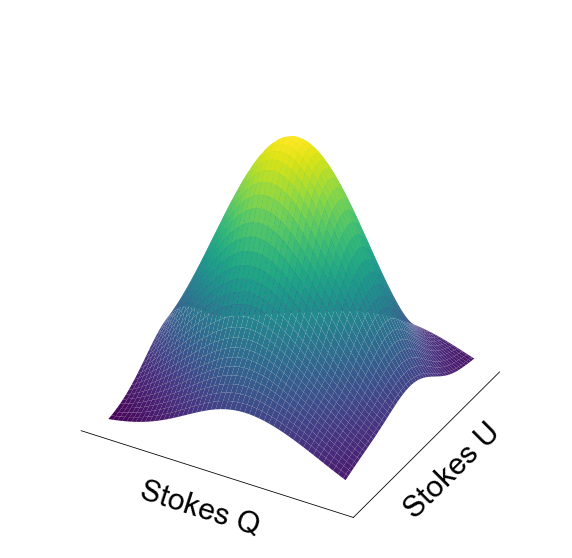

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot_surface(X,Y,Z,cmap="viridis")
"""ax.view_init(50,45)"""
ax.set_xlabel(r"Stokes Q",size=30,fontname="Arial")
ax.set_ylabel(r"Stokes U",size=30,fontname="Arial")

# Hide Background Color 
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Hide Z Axis 
ax.w_zaxis.line.set_lw(0.)


# Hide axis
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.savefig(posterdir+"KDE_3D.png",overwrite=True,transparent=True,dpi=300)
plt.savefig(figdir+"KDE/KDE_3D.png",overwrite=True,transparent=True,dpi=300)

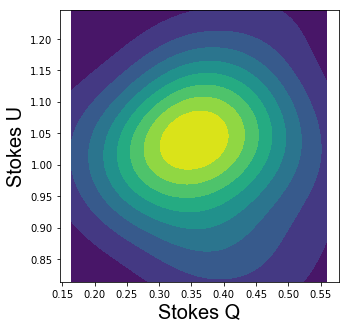

In [18]:
ncplot(X,Y,Z)
plt.savefig(posterdir+"KDE_contour.png",overwrite=True,transparent=True,dpi=300)
plt.savefig(figdir+"KDE/KDE_contour.png",overwrite=True,transparent=True,dpi=300)

In [126]:
#Making real Gaussian
def fit_gaussian(X,Y,Z):
    g2D_init = Gaussian2D(amplitude=np.max(Z), 
                          x_mean=X[np.unravel_index(np.argmax(Z),Z.shape)], 
                          y_mean=Y[np.unravel_index(np.argmax(Z),Z.shape)], 
                          x_stddev=np.std(X), 
                          y_stddev=np.std(Y), 
                          bounds={'theta': (-2*np.pi,2*np.pi),
                                  'x_mean': (np.min(X),np.max(X)),
                                  'y_mean': (np.min(Y),np.max(Y)),
                                  'x_stddev':(0.001,1),
                                  'y_stddev':(0.001,1)})
    g2D = fitter(g2D_init, X, Y, Z, weights = Z)
    G = g2D.evaluate(X,Y,g2D.amplitude.value,g2D.x_mean.value,g2D.y_mean.value,g2D.x_stddev.value,g2D.y_stddev.value,g2D.theta.value)
    return g2D,G
g2D,G = fit_gaussian(Xo,Yo,Zo)
ecc = find_ecc(g2D)
ecc

0.47915750458334083

In [133]:
#Making test Gaussian with theta = 0
def fit_test_gaussian(X,Y,Z):
    g2D_test_init = Gaussian2D(amplitude=np.max(Z), 
                               x_mean=X[np.unravel_index(np.argmax(Z),Z.shape)], 
                               y_mean=Y[np.unravel_index(np.argmax(Z),Z.shape)], 
                               x_stddev=np.std(X), 
                               y_stddev=np.std(Y), 
                               fixed={'theta':True}, 
                               bounds={'x_mean': (np.min(X),np.max(X)),
                                       'y_mean': (np.min(Y),np.max(Y)),
                                       'x_stddev':(0.001,1),
                                       'y_stddev':(0.001,1)})
    g2D_test_init.y_stddev = g2D_test_init.x_stddev
    g2D_test = fitter(g2D_test_init, X, Y, Z, weights = Z)
    stddev = np.mean([g2D_test.x_stddev.value,g2D_test.y_stddev.value])
    g2D_test.x_stddev.value = stddev
    g2D_test.y_stddev.value = stddev
    G_test = g2D_test.evaluate(X,Y,g2D_test.amplitude.value,g2D_test.x_mean.value,g2D_test.y_mean.value,g2D_test.x_stddev.value,g2D_test.y_stddev.value,g2D_test.theta.value)
    return g2D_test,G_test
g2D_test,G_test = fit_test_gaussian(Xo,Yo,Zo)

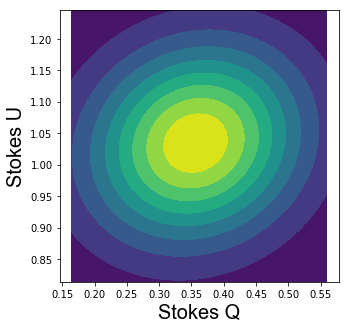

In [127]:
ncplot(X,Y,G)
plt.savefig(figdir+"KDE/gaussian.png",overwrite=True,transparent=True,dpi=300)

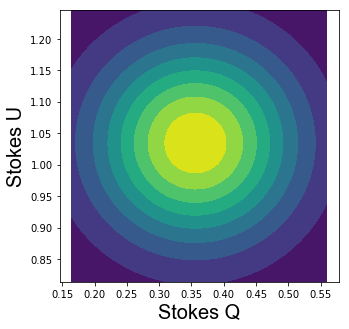

In [101]:
ncplot(X,Y,G_test)
plt.savefig(figdir+"KDE/test_gaussian.png",overwrite=True,transparent=True,dpi=300)

In [102]:
def resids(Z,G):
    residuals = ((Z-G)**2)/Z
    return residuals
residuals = resids(Z,G)

In [103]:
test_residuals = resids(Z,G_test)

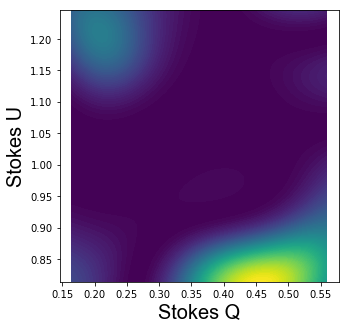

In [104]:
ncplot(X,Y,residuals,n=100)
plt.savefig(figdir+"KDE/residuals.png",overwrite=True,transparent=True,dpi=300)

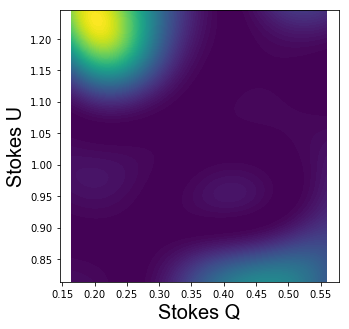

In [105]:
ncplot(X,Y,test_residuals,n=100)
plt.savefig(figdir+"KDE/test_residuals.png",overwrite=True,transparent=True,dpi=300)

In [ ]:
def model_chi(residuals,test_residuals,Z):
    sig=(np.sum(test_residuals)-np.sum(residuals))/(2*len(Z))
    return sig
sig = model_chi(residuals,test_residuals,Z)
sig
#More or less significant :-) KS test

## KDE Significance
To figure out if the eccentricity of our KDE is significant we need to do some statistics. To do this we must:   
1. Take 10,000 random samplings from the circular gaussian with the *Same number of data points*   
2. Make KDE from those random samplings
3. At each point of the KDE, see what fraction of the samples are above or below the original.
4. Plot that surface, should be at about 0.5?

In [ ]:
#Taking samples
samples = np.random.multivariate_normal([g2D_test.x_mean.value,g2D_test.y_mean.value],[[g2D_test.x_stddev**2,0],[0,g2D_test.y_stddev**2]],size=34)
sx = samples[:,0]
sy = samples[:,1]
plt.scatter(sx,sy)
plt.scatter(ave_qs,ave_us)
#KDE
X_sample,Y_sample,Z_sample = KDE(sx,sy,X=Xo,Y=Yo)
ncplot(X_sample,Y_sample,Z_sample)
plt.show()
#Making real Gaussian
g2D_sample,G_sample = fit_gaussian(X_sample,Y_sample,Z_sample)
ecc_sample = find_ecc(g2D_sample)
print(ecc_sample)
ncplot(X_sample,Y_sample,G_sample)
plt.show()
#Making test gaussian
G_sample_test = g2D_test.evaluate(X_sample,Y_sample,g2D_test.amplitude.value,g2D_test.x_mean.value,g2D_test.y_mean.value,g2D_test.x_stddev.value,g2D_test.y_stddev.value,g2D_test.theta.value)
ncplot(X_sample,Y_sample,G_sample_test)
plt.show()
#find signifigance
sample_residuals = resids(Z_sample,G_sample)
test_sample_residuals = resids(Z_sample, G_sample_test)
sample_sig = model_chi(sample_residuals,test_sample_residuals,Z_sample)
print(sample_sig)

In [ ]:
all_x,all_y=[],[]
n=10000
#creates n samples and stores each of the x,y coordinates in nested arrays
for i in range(n):
    samples = np.random.multivariate_normal([g2D_test.x_mean.value,g2D_test.y_mean.value],[[g2D_test.x_stddev**2,0],[0,g2D_test.y_stddev**2]],size=34)
    all_x.append(samples[:,0])
    all_y.append(samples[:,1])
all_x,all_y = np.array(all_x),np.array(all_y)

In [ ]:
#getting rid of warnings so I don't want to scream
import sys
warnings.filterwarnings("ignore","""You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.""")
warnings.filterwarnings("ignore","""The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.""")
all_Z = []
#runs through each sample
for i in range(n):
    #prints percentage when it gets to a whole number, so I know how far along the run is
    p = (((i+1)/n)*100)
    if p.is_integer():
        sys.stdout.write('\r'+str(int(p))+"%")
    #computes a KDE for each sample, then computes the value at each point of the original KDE, Xo and Yo.
    X,Y,Z = KDE(all_x[i],all_y[i],X=Xo,Y=Yo)
    all_Z.append(Z)

In [ ]:
all_Z = np.array(all_Z)

In [ ]:
diff_Z = []
for test_Z in all_Z:   #For each sample KDE
    bigger_plane = []
    for test_row,real_row in zip(test_Z,Zo):   #For each row in the sample, and our original KDE
        bigger_row = []
        for t,o in zip(test_row,real_row):    #For each value in the rows of the sample, and our original KDE
            if t > o:
                bigger_row.append(1)    #If the sample is larger than our KDE at that point, mark as one
            else:
                bigger_row.append(0)    #If not, mark as zero
        bigger_plane.append(np.array(bigger_row))     #Recombine all the values and rows, and sample KDEs into one big array
    diff_Z.append(np.array(bigger_plane))
test_Z = diff_Z           
diff_Z = np.sum(diff_Z,axis=0)/n    #Calculate, at each X,Y point, what fraction of sample KDEs were larger than our original KDE

In [ ]:
pd.DataFrame(diff_Z).to_csv(datadir+"KDE/diff_Z.dat")

In [ ]:
ncplot(Xo,Yo,np.std(all_Z,axis=0))

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot_surface(Xo,Yo,diff_Z,cmap="viridis")
plt.savefig(figdir+"KDE/model_test_surface.png",overwrite=True,transparent=True,dpi=300)

In [ ]:
ax,obj = ncplot(Xo,Yo,diff_Z)
plt.colorbar(ax=ax,mappable=obj)
plt.savefig(figdir+"KDE/model_test_contour.png",overwrite=True,transparent=True,dpi=300)

In [ ]:
#I don't think that this a good way to evaluate the models
'''t = 0
n = 1000
warnings.filterwarnings("ignore","""You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.""")
warnings.filterwarnings("ignore","""The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.""")
for i in range(n):
    #Taking samples
    samples = np.random.multivariate_normal([g2D_test.x_mean.value,g2D_test.y_mean.value],[[g2D_test.x_stddev**2,0],[0,g2D_test.y_stddev**2]],size=34)
    sx = samples[:,0]
    sy = samples[:,1]
    #KDE
    X_sample,Y_sample,Z_sample = KDE(sx,sy)
    #Making real Gaussian
    g2D_sample,G_sample = fit_gaussian(X_sample,Y_sample,Z_sample)
    #Making test gaussian
    g2D_sample_test,G_sample_test = fit_test_gaussian(X_sample,Y_sample,Z_sample)
    #find signifigance
    sample_residuals = resids(Z_sample,G_sample)
    test_sample_residuals = resids(Z_sample, G_sample_test)
    sample_sig = model_chi(sample_residuals,test_sample_residuals,Z_sample)
    if sample_sig >= sig:
        t += 1
p = (t/n)*100
print(p)'''

# Testing System With Known Position Angle

To see how valid this method is we want to try out what we did with P Cyg data on another system with a known prefered position angle.

In [27]:
vdf = pd.read_csv(datadir+"KDE/VBandData.txt",delim_whitespace=True)
vx,vy,vz = KDE(vdf.Q,vdf.U)

C:\Users\Keyan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Keyan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


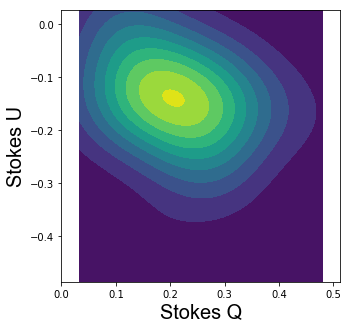

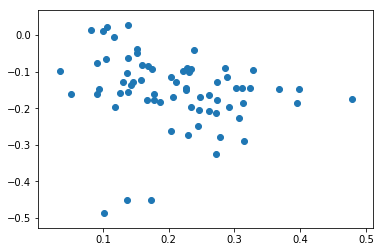

In [28]:
cax, c = ncplot(vx,vy,vz)
f,ax=plt.subplots()
ax.scatter(vdf.Q,vdf.U)

In [130]:
vg2D,vG = fit_gaussian(vx,vy,vz)

(<matplotlib.axes._subplots.AxesSubplot at 0x231bb0a6a20>,
 <matplotlib.contour.QuadContourSet at 0x231bb0af390>)

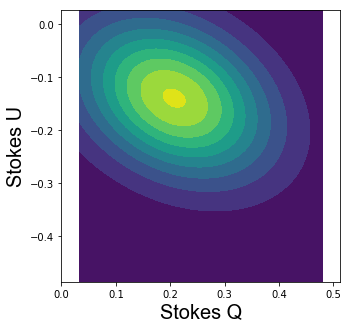

In [131]:
ncplot(vx,vy,vG)

In [132]:
guess_pa = vg2D.theta*u.rad.to(u.deg)/2
guess_pa

74.45150306208248

In [134]:
test_vg2D,test_vG = fit_test_gaussian(vx,vy,vz)

(<matplotlib.axes._subplots.AxesSubplot at 0x231bb452240>,
 <matplotlib.contour.QuadContourSet at 0x231bb15e160>)

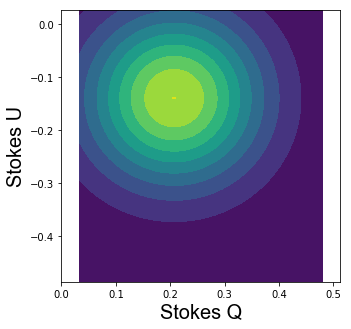

In [135]:
ncplot(vx,vy,test_vG)

In [139]:
all_x,all_y=[],[]
n=10
#creates n samples and stores each of the x,y coordinates in nested arrays
for i in range(n):
    samples = np.random.multivariate_normal([test_vg2D.x_mean.value,test_vg2D.y_mean.value],[[test_vg2D.x_stddev**2,0],[0,test_vg2D.y_stddev**2]],size=vdf.Q.size)
    all_x.append(samples[:,0])
    all_y.append(samples[:,1])
all_x,all_y = np.array(all_x),np.array(all_y)

In [141]:
#getting rid of warnings so I don't want to scream
import sys
warnings.filterwarnings("ignore","""You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.""")
warnings.filterwarnings("ignore","""The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.""")
all_Z = []
#runs through each sample
for i in range(n):
    #prints percentage when it gets to a whole number, so I know how far along the run is
    p = (((i+1)/n)*100)
    if p.is_integer():
        sys.stdout.write('\r'+str(int(p))+"%")
    #computes a KDE for each sample, then computes the value at each point of the original KDE, Xo and Yo.
    X,Y,Z = KDE(all_x[i],all_y[i],X=Xo,Y=Yo)
    all_Z.append(Z)

100%

In [142]:
all_Z = np.array(all_Z)

In [143]:
diff_Z = []
for test_Z in all_Z:   #For each sample KDE
    bigger_plane = []
    for test_row,real_row in zip(test_Z,Zo):   #For each row in the sample, and our original KDE
        bigger_row = []
        for t,o in zip(test_row,real_row):    #For each value in the rows of the sample, and our original KDE
            if t > o:
                bigger_row.append(1)    #If the sample is larger than our KDE at that point, mark as one
            else:
                bigger_row.append(0)    #If not, mark as zero
        bigger_plane.append(np.array(bigger_row))     #Recombine all the values and rows, and sample KDEs into one big array
    diff_Z.append(np.array(bigger_plane))
test_Z = diff_Z           
diff_Z = np.sum(diff_Z,axis=0)/n    #Calculate, at each X,Y point, what fraction of sample KDEs were larger than our original KDE

(<matplotlib.axes._subplots.AxesSubplot at 0x231bb1a8518>,
 <matplotlib.contour.QuadContourSet at 0x231bb197550>)

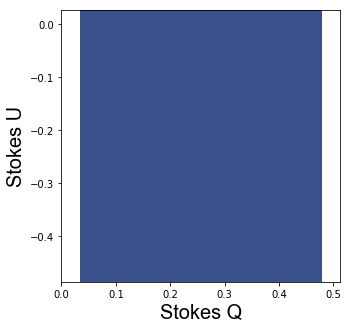

In [144]:
ncplot(vx,vy,diff_Z)